# Feature Discovery & Extraction Experiement

The purpose of this experiement is to explore the URL dataset and attempt to find significant, useful features to attach to the dataset for training our ML models.

The 1st identified type of features that will be explored is Lexical-based features: These are based on characteristics of the makeup of the URL strings themselves.

Examples would be: 
- Length of URL
- How many sub-domains
- Length of Top Level Domain (TLD)
<br/>... etc

Firstly, the data for Benign and Malicious classed URLs will be joined into 1 dataset:

In [102]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.feature_selection import SelectKBest, f_classif, chi2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, plot_roc_curve, average_precision_score

from featureprocessing import LexicalFeatureProcessing as lfp
from datacleaning import URLDataCleaning as ucl

from sklearn.datasets import load_iris

In [2]:
import pandas as pd

df_benign = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Benign_list_big_final.csv')
df_benign["URLType"] = "Benign"

df_malicious = pd.read_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/Malicious-DS/URL/Malware_dataset.csv')
df_malicious["URLType"] = "Malicious"

dfs = [df_benign, df_malicious]
df = pd.concat(dfs)
df.reset_index(drop=True, inplace=True)
df = df.sample(frac=1).reset_index(drop=True)

display(df)

,URL,URLType
0,http://mylust.com/videos/215137/my-raunchy-loo...,Benign
1,http://mic.com/articles/101766/one-perfect-twe...,Benign
2,http://stackexchange.com/newsletters/newslette...,Benign
3,http://bisaneema.org/%e0%a4%ad%e0%a4%be%e0%a4%...,Malicious
4,http://skyrock.com/videos/eDJwODRhNzoxMw==-bug...,Benign
...,...,...
46939,http://themeforest.net/item/artistas-modern-po...,Benign
46940,http://torcache.net/torrent/2EE5318B3923B273EF...,Benign
46941,http://grasslandhotel.com.vn/index.php/compone...,Malicious
46942,http://conservativetribune.com/barack-obama-ju...,Benign


Next, the classes Benign/Malicious will be label encoded, prepping them so that they can be used by ML models:
- Benign | 0
- Malicious | 1

In [3]:
enc = preprocessing.LabelEncoder()
df["URLType"] = enc.fit_transform(df.URLType.values)

This will be saved as the base dataset that can be built upon with whatever features to be experimented with:

In [4]:
df.to_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/dataset.csv', index=False)

The next step is to extract a list of lexical features from the URLs to create a full dataset.<br/>
The URLs will need to be cleaned to ensure that they are formatted correctly to extract URL based features using existing Pyhton librarieslike tld etc:

In [5]:
feature_list = []
for index, row in df.iterrows():
    row["URL"] = ucl.clean_data(row["URL"])
    feature_dict = lfp.extract(row["URL"])
    feature_dict.update({"URLType": row["URLType"]})
    feature_list.append(feature_dict)

df_features = pd.DataFrame(feature_list)
display(df_features)

,URLLength,HostLength,TLDLength,DotCount,DashCount,@Count,%Count,=Count,?Count,DigitCount,UniqueCharCount,URLType
0,93,10,3,1,7,0,0,0,0,6,30,0
1,116,7,3,1,14,0,0,0,0,6,29,0
2,83,17,3,3,0,0,0,1,1,0,26,0
3,196,13,3,1,3,0,57,0,0,51,27,1
4,91,11,3,2,5,0,0,4,1,5,41,0
...,...,...,...,...,...,...,...,...,...,...,...,...
46939,93,15,3,1,4,0,0,0,0,8,31,0
46940,136,12,3,10,0,0,0,1,1,32,42,0
46941,76,21,6,4,0,0,0,0,0,1,25,1
46942,98,23,3,1,11,0,0,0,0,0,25,0


Lets analyse the existing correlations/relationships that these engineered features have amoungest eachother

The feature extracted dataset will be saved for future retrieval without having perform another extraction:

In [6]:
df_features.to_csv('/Users/chrismclearnon/Developer/QUB-CSC3032-FYP/src/data/feature_dataset.csv', index=False)

In order to ensure that meaningful & impactful features will be used by ML models, they will have to be analysed using statistical methods in order to find the features that have the biggest impact, and filter out any features that have either the same values across most if not all records, or have very little impact on the class.<br/><br/>
The dataset will be split into train & test sets for fitting to the feature selector:

In [122]:
df_array = df_features.values
x = df_array[:, 0:11]
y = df_array[:, 11]

# sns.pairplot(df_features)
# plt.show()

The 1st experiment for feature selection will use Chi-Squared analysis of the feature set, to select a specified number of features that have the highest correlation with the class set:

![title](img/ChiSquared.png)<br/><br/>

For a base test, we will select the top 5 features from the dataset:

In [89]:
chi2_selector = SelectKBest(chi2, k=5)
chi2_fit = chi2_selector.fit(x, y)

np.set_printoptions(precision=4, suppress=True)
display(chi2_fit.scores_)

chi2_x = chi2_fit.transform(x)
display(chi2_x)

array([78915.3437,  1684.7449,   595.8744,   445.415 , 52358.421 ,
          41.5609, 13135.5282,   913.9615,    35.0667,   559.7116,
        4680.1887])

array([[ 93,  10,   7,   0,  30],
       [116,   7,  14,   0,  29],
       [ 83,  17,   0,   0,  26],
       ...,
       [ 76,  21,   0,   0,  25],
       [ 98,  23,  11,   0,  25],
       [ 86,  11,   0,   0,  22]])

In [90]:
x_scaled = preprocessing.scale(x)
chi2_x_scaled = preprocessing.scale(chi2_x)

X_train, x_test, Y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 42)
Chi_X_train, chi_x_test, Chi_Y_train, chi_y_test = train_test_split(chi2_x_scaled, y, test_size = 0.2, random_state = 42)

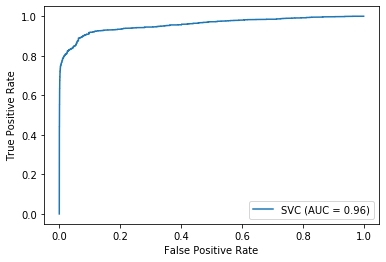

In [100]:
base_clf = SVC()
base_clf.fit(X_train, Y_train)

y_pred = base_clf.predict(x_test)
base_acc_score = accuracy_score(y_test, y_pred)

svc_disp = plot_roc_curve(base_clf, x_test, y_test)
plt.show()

Base Classifier Acc Score: 0.938
Chi Squared Feature Selected Classifier Acc Score: 0.945


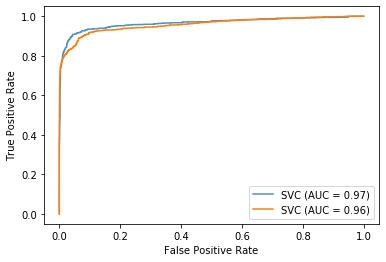

In [107]:
chi2_clf = SVC()
chi2_clf.fit(Chi_X_train, Chi_Y_train)

ax = plt.gca()

chi_y_pred = chi2_clf.predict(chi_x_test)
chi2_acc_score = accuracy_score(chi_y_test, chi_y_pred)

print('Base Classifier Acc Score: {0:0.3f}\nChi Squared Feature Selected Classifier Acc Score: {1:0.3f}'.format(base_acc_score, chi2_acc_score))

chi_svc_disp = plot_roc_curve(chi2_clf, chi_x_test, chi_y_test, ax=ax, alpha=0.8)
svc_disp.plot(ax=ax)
plt.show()

It can be observed from the plot above that whenever the Chi Squared statistical analysis is applied to the dataset, and the top 5 features are selected:<br/>
- Increase in model prediction accuracy for a default SVM classifier
- Improved AUC for Receiver Operating Characteristic (ROC)

In [108]:
from sklearn.neighbors import KNeighborsClassifier

In [118]:
base_neigh = KNeighborsClassifier()
base_neigh.fit(X_train, Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [119]:
base_neigh_y_pred = base_neigh.predict(x_test)
base_neigh_acc_score = accuracy_score(y_test, base_neigh_y_pred)
print('Base KNN Classifier Acc Score: {0}'.format(base_neigh_acc_score))

Base KNN Classifier Acc Score: 0.9847694110128874


In [120]:
chi2_neigh = KNeighborsClassifier()
chi2_neigh.fit(Chi_X_train, Chi_Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [121]:
chi2_neigh_y_pred = chi2_neigh.predict(chi_x_test)
chi2_neigh_acc_score = accuracy_score(chi_y_test, chi2_neigh_y_pred)
print('Base KNN Classifier Acc Score: {0}'.format(chi2_neigh_acc_score))

Base KNN Classifier Acc Score: 0.9779529236340399
